C:\Users\admin\AppData\Local\Temp\ipykernel_6004\2834714528.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(unique_groups))


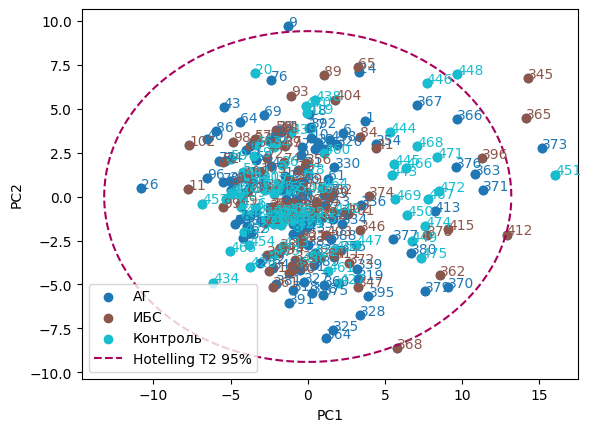

Items that went out 95%: [9, 373, 345, 365, 451]


In [140]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.cm as cm

def hotellings(scores, groups, numbers):
    a = 0.95
    n = len(scores)
    p = len(scores[0])
    
    f = ss.f.ppf(a, p, n - p)
    
    sx = np.std(scores[:, 0])
    sy = np.std(scores[:, 1])
    
    m = [np.pi * x / 100.0 for x in range(200)]
    cx = np.cos(m) * sx * f
    cy = np.sin(m) * sy * f
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    plt.scatter(scores[:, 0], scores[:, 1])
    
    # Color by groups
    unique_groups = np.unique(groups)
    colors = cm.get_cmap('tab10', len(unique_groups))
    
    outliers = []
    
    for i, group in enumerate(unique_groups):
        group_scores = scores[groups == group]
        plt.scatter(group_scores[:, 0], group_scores[:, 1], color=colors(i), label=group)
        
        # Find outliers in the group
        outliers_mask = np.logical_or(
            np.abs(group_scores[:, 0] - np.mean(group_scores[:, 0])) > f * sx,
            np.abs(group_scores[:, 1] - np.mean(group_scores[:, 1])) > f * sy
        )
        outliers.extend(numbers[groups == group][outliers_mask])
        
        # Annotate for number
        for j, number in enumerate(numbers[groups == group]):
            plt.annotate(number, (group_scores[j, 0], group_scores[j, 1]), color=colors(i))
    
    plt.plot(cx, cy, '--', color='#a8005c', label='Hotelling T2 95%')    
    plt.legend(loc='lower left') 
    plt.show()
    
    return cx, cy, outliers

# Load the data
data = pd.read_excel('C:/Users/admin/Documents/norm_CVD.xlsx')

# Perform PCA
pca = PCA(n_components=2)
data_clear = data.drop('Group', axis=1)
data_clear = data_clear.drop('Number', axis=1)
pca_data = pca.fit_transform(data_clear)

# Call the hotellings function with PCA scores and group information
_, _, outliers = hotellings(pca_data, data['Group'], data['Number'])

# Print the items that went out 95%
print("Items that went out 95%:", outliers)

In [141]:
df_stat = data.drop('Number', axis=1)

In [148]:
import pandas as pd
import streamlit as st
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.multitest as mt

# Assuming you have a DataFrame df_stat with metabolite data where each row represents a sample
# and the 'Group' column contains the names of the groups related to each sample
groups = df_stat['Group'].unique()

for index, group_name in enumerate(groups):
    p_values = []
    stat_values = []
    q_values = []
    distributions = []
    group_data = df_stat[df_stat['Group'] == group_name]
    group_data = group_data.drop('Group', axis=1)
    for column in group_data.columns:
        # Perform normality test
        normality_result = stats.shapiro(group_data[column])
        pval_normality = normality_result[1]
        pval_normality = "{:.2e}".format(pval_normality)
        p_values.append(float(pval_normality))
        
        if float(pval_normality) < 0.05:
            distributions.append("Normal")
            # Perform ANOVA
            anova_result = stats.f_oneway(*[df_stat[df_stat['Group'] == name][column] for name in groups])
            stat_values.append(anova_result.pvalue)
            q_value = float(mt.multipletests(stat_values, method='bonferroni')[1][-1])
            q_values.append(q_value)
        else:
            distributions.append("Non-normal")
            # Perform Kruskal-Wallis test
            kruskal_result = stats.kruskal(*[df_stat[df_stat['Group'] == name][column] for name in groups])
            stat_values.append(kruskal_result.pvalue)
            q_value = float(mt.multipletests(stat_values, method='bonferroni')[1][-1])
            q_values.append(q_value)

    data = pd.DataFrame({
        "Metabolite": group_data.columns,
        "P-value (Shapiro)": p_values[:len(group_data.columns)],
        "Distribution": distributions[:len(group_data.columns)],
        "Method": ["ANOVA" if pval < 0.05 else "Kruskal-Wallis" for pval in p_values[:len(group_data.columns)]],
        "P-value (Stat Test)": stat_values[:len(group_data.columns)],
        "Q-value": q_values[:len(group_data.columns)],
    })

    print(data)
    #Save in excel
    data.to_excel('C:/Users/admin/Documents/Group_CVD.xlsx', index=False)

                 Metabolite  P-value (Shapiro) Distribution          Method  \
0   3-OH Anthranillic acids       2.720000e-17       Normal           ANOVA   
1      5-hydroxytryptophans       2.410000e-10       Normal           ANOVA   
2      5-Methoxytryptamines       1.350000e-01   Non-normal  Kruskal-Wallis   
3                 adenosins       4.420000e-18       Normal           ANOVA   
4                     ADMAs       6.180000e-03       Normal           ANOVA   
..                      ...                ...          ...             ...   
87                   C5-OHs       3.220000e-02       Normal           ANOVA   
88                      C6s       2.590000e-06       Normal           ANOVA   
89                   C6-DCs       2.980000e-08       Normal           ANOVA   
90                      C8s       1.200000e-05       Normal           ANOVA   
91                    C8-1s       1.700000e-19       Normal           ANOVA   

    P-value (Stat Test)  Q-value  
0              1